In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), (
            "only supporting int/float powers for now"
        )
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), "tanh")

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        top_ord = []
        visited = set()

        def build_top_ord(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_top_ord(child)
                top_ord.append(v)

        build_top_ord(self)

        self.grad = 1.0
        for node in top_ord[::-1]:
            node._backward()

In [3]:
from graphviz import Digraph


def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    # Build the graph with a DFS approach
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = Left to Right
    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))
        dot.node(
            name=uid,
            label="{%s |data %.4f | grad %.4f}"
            % (
                node.label,
                node.data,
                node.grad,
            ),
            shape="record",
        )
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

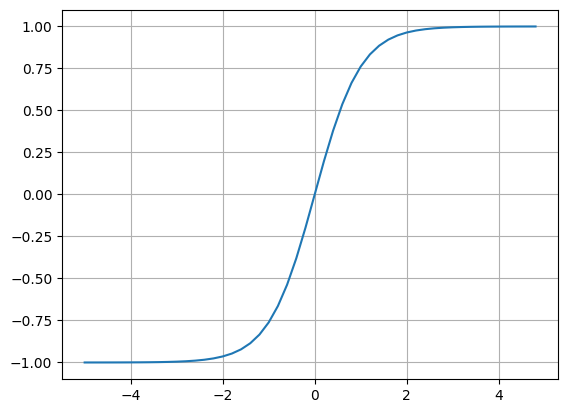

In [4]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.show()

In [5]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1+x2w2"

n = x1w1x2w2 + b
n.label = "n"

o = n.tanh()
o.label = "o"
o.backward()

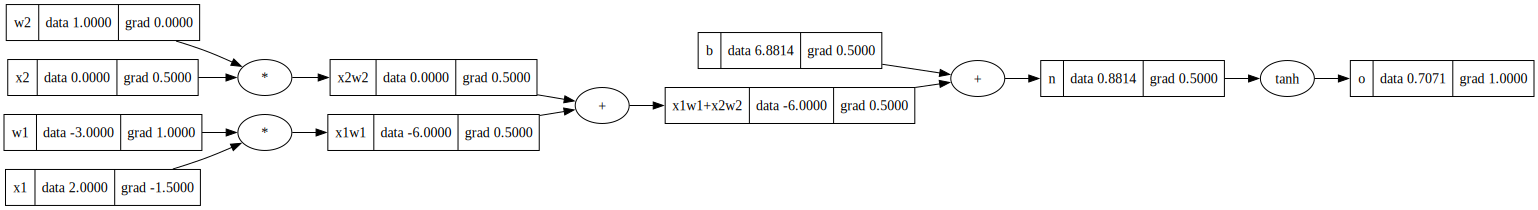

In [6]:
draw_dot(o)

do/db = do/dn * dn/db = 1 * dn/db = dn/db
do/ddx1w1x2w2 = do/dn * dn/ddx1w1x2w2 = 1 * dn/ddx1w1x2w2 = dn/ddx1w1x2w2

do/dx1 = do/dx1w1 * dx1w1/dx1 = do/dx1w1 * w1
do/dx2 = do/dx2w2 * dx2w2/dx2 = do/dx2w2 * w2

do/dw1 = do/dx1w1 * dx1w1/dw1 = do/dx1w1 * x1
do/dw2 = do/dx2w2 * dx2w2/dw2 = do/dx2w2 * x2


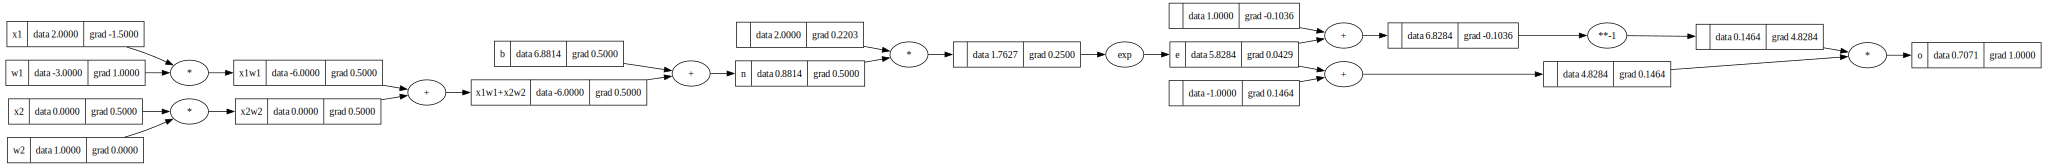

In [7]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1+x2w2"

n = x1w1x2w2 + b
n.label = "n"

e = (2 * n).exp()
e.label = "e"

o = (e - 1) / (e + 1)

o.label = "o"
o.backward()
draw_dot(o)

In [8]:
import torch
from torch import Tensor

x1 = Tensor([2.0]).double()
x1.requires_grad = True

x2 = Tensor([0.0]).double()
x2.requires_grad = True

w1 = Tensor([-3.0]).double()
w1.requires_grad = True

w2 = Tensor([1.0]).double()
w2.requires_grad = True

b = Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)
o.backward()

In [9]:
print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1), label=f"w_{i}") for i in range(nin)]
        self.b = Value(random.uniform(-1, 1), label="b")

    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [11]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.49031766925690284, grad=0.0)

In [12]:
len(n.parameters())

41

In [13]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [16]:
for k in range(30):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)

0 0.34990815163519756
1 0.3346550132224474
2 0.32051000527857376
3 0.30736410490646104
4 0.29512157504876574
5 0.2836980559573946
6 0.2730189699145101
7 0.2630181816962809
8 0.25363686890041637
9 0.24482256532734592
10 0.23652834772131714
11 0.22871214179537305
12 0.22133612792383014
13 0.2143662304452403
14 0.20777167737413096
15 0.2015246196214847
16 0.1955998006878905
17 0.18997426930950062
18 0.18462712877548468
19 0.17953931765152464
20 0.17469341748033065
21 0.17007348372147152
22 0.16566489676618834
23 0.1614542303401174
24 0.15742913500538555
25 0.15357823480743205
26 0.14989103539249865
27 0.14635784215824543
28 0.1429696871998685
29 0.13971826398357512


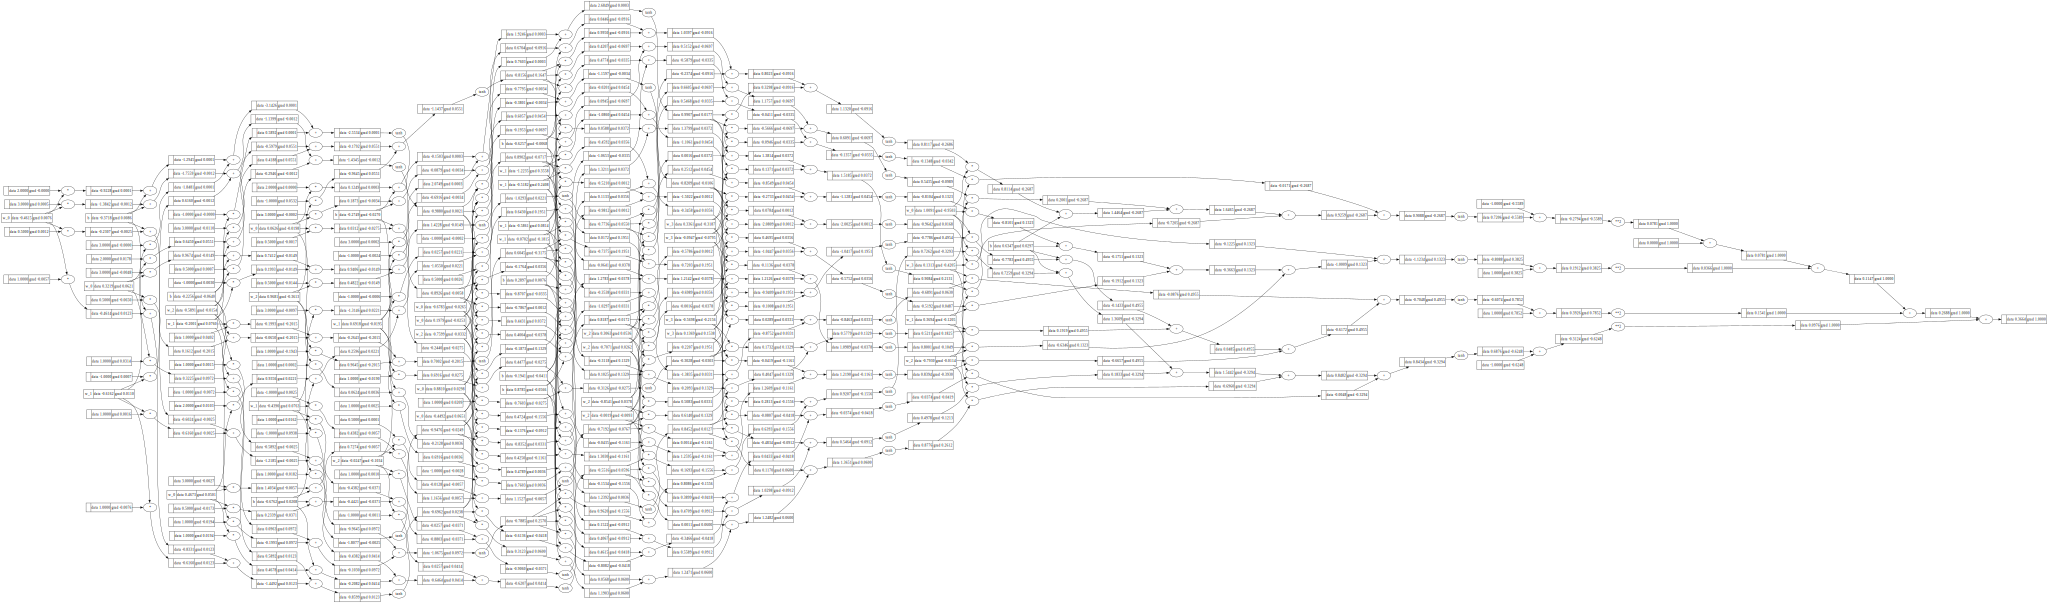

In [15]:
draw_dot(loss)